# LST Integration Correction

This notebook takes a quick look at the performance of the ctapipe `integration_correction` method for the LST low-gain pulse shape. This is performed with the `sstcam-simulation` package.

In [248]:
from sstcam_simulation import Camera, EventAcquisition, SimtelReader, PhotoelectronSource
from sstcam_simulation.camera.spe import PerfectPhotosensor
from sstcam_simulation.plotting import CameraImage
from sstcam_simulation.camera.pulse import CONTINUOUS_READOUT_SAMPLE_WIDTH, GenericPulse
from ctapipe.image.extractor import NeighborPeakWindowSum
from glob import glob
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from numba import njit, prange
%matplotlib inline

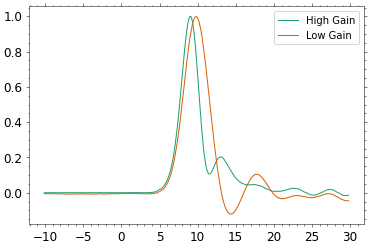

In [247]:
t, hg, lg = np.loadtxt("pulse_LST_8dynode_pix6_20200204.dat", unpack=True)
plt.plot(t, hg, label="High Gain")
plt.plot(t, lg, label="Low Gain")
plt.legend()

In [249]:
paths = glob("/Users/Jason/Downloads/tempdata/d200616_prod4/proton/*.simtel.gz")

camera = Camera(
    continuous_readout_duration=128,
    photoelectron_spectrum=PerfectPhotosensor(),
    reference_pulse=GenericPulse(t, lg)
)
acquisition = EventAcquisition(camera)
source = PhotoelectronSource(camera)

## Reference Pulse Shape

Text(0, 0.5, 'Amplitude (Area == 1)')

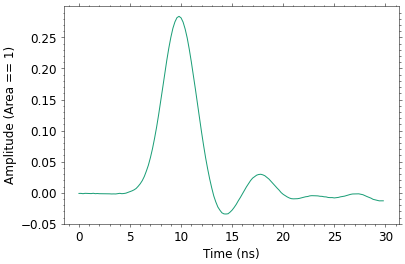

In [250]:
plt.plot(camera.reference_pulse.time, camera.reference_pulse.pulse)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (Area == 1)")

## Demonstrate photon pile-up

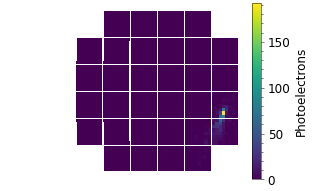

In [251]:
# Obtain example event
reader = SimtelReader(paths[0], only_triggered_events=True)
for pe in reader:
    break
    
image = CameraImage.from_coordinates(camera.mapping.pixel, talk=True)
image.add_colorbar("Photoelectrons")
image.image = pe.get_photoelectrons_per_pixel(2048)
plt.pause(1)

Photonelectron Arrival Time Range: 31.59 - 34.06 ns


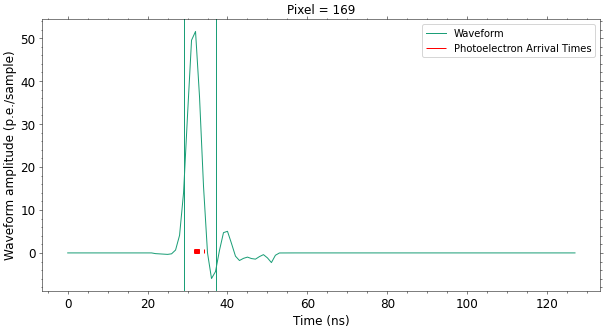

In [266]:
pe_resampled = acquisition.resample_photoelectron_charge(pe)
readout = acquisition.get_continuous_readout(pe_resampled)
waveform = acquisition.get_sampled_waveform(readout)
    
max_pixel = pe.get_photoelectrons_per_pixel(camera.mapping.n_pixels).argmax()
time = pe.time[pe.pixel == max_pixel]
fig, ax = plt.subplots(figsize=(10, 5))
ax.vlines(time, ymin=0, ymax=1, color='red', label="Photoelectron Arrival Times")
ax.plot(waveform[max_pixel], label="Waveform")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Waveform amplitude (p.e./sample)")
ax.legend()
ax.set_title(f"Pixel = {max_pixel}")

ax.axvline(waveform[max_pixel].argmax() - 3)
ax.axvline(waveform[max_pixel].argmax() - 3 + 8)

print(f"Photonelectron Arrival Time Range: {time.min():.2f} - {time.max():.2f} ns")

In [265]:
waveform.shape

(2048, 128)

## Process Events

In [253]:
# Define an extractor with no correction
class NeighborPeakWindowSumNoCorrection(NeighborPeakWindowSum):
    def _calculate_correction(self, telid):
        return np.full(1, 1)

In [275]:
subarray = camera.ctapipe_subarray
extractors = dict(
    wc_3_1=NeighborPeakWindowSum(subarray=subarray, window_width=3, window_shift=1),
    wc_20_10=NeighborPeakWindowSum(subarray=subarray, window_width=20, window_shift=10),
    nc_3_1=NeighborPeakWindowSumNoCorrection(subarray=subarray, window_width=3, window_shift=1),
    nc_20_10=NeighborPeakWindowSumNoCorrection(subarray=subarray, window_width=20, window_shift=10),
)

In [276]:
@njit(fastmath=True, parallel=True)
def get_median_time_per_pixel(pixel, time, n_pixels):
    median_time = np.zeros(n_pixels)
    for p in np.unique(pixel):
        index = p == pixel
        median_time[p] = np.median(time[index])
    return median_time

In [277]:
nsb_rate = 100
# Calculate pedestal
pedestal = {}
for name, extractor in extractors.items():
    n_events = 100
    charge_measured = np.zeros((n_events, camera.mapping.n_pixels))
    for i in range(n_events):
        nsb = source.get_nsb(nsb_rate)
        readout = acquisition.get_continuous_readout(nsb)
        waveform = acquisition.get_sampled_waveform(readout)
        charge_measured[i] = waveform[:, 30:30+extractor.window_width.tel[1]].sum(1)
    pedestal[name] = a.mean()

In [278]:
pixels = np.arange(camera.mapping.n_pixels)
df_list = []
waveform_list = []
pedestal_waveform_list = []
i = 0
for path in tqdm(paths):
    reader = SimtelReader(path, only_triggered_events=True)
    for signal_pe in tqdm(reader):
        i+=1
        nsb_pe = source.get_nsb(nsb_rate)
        readout = acquisition.get_continuous_readout(signal_pe + nsb_pe)
        waveform = acquisition.get_sampled_waveform(readout)
        charge_true = signal_pe.get_photoelectrons_per_pixel(camera.mapping.n_pixels)
        
        for name, extractor in extractors.items():
            charge_measured = extractor(waveform, 1, 0)[0]
            charge_measured -= pedestal[name]
            df_list.append(pd.DataFrame(dict(
                pixel=pixels,
                charge_measured=charge_measured,
                charge_true=charge_true,
                name=name,
            )))
        
        if i > 100:
            break
    break

df = pd.concat(df_list, ignore_index=True)

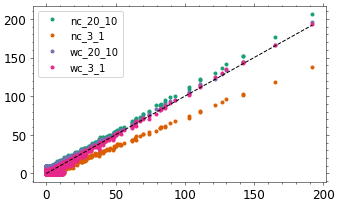

In [279]:
for name, group in df.groupby('name'):
    plt.plot(group['charge_true'], group['charge_measured'], '.', label=name)
    
ref = [df['charge_true'].min(), df['charge_true'].max()]
plt.plot(ref, ref, color='black', ls='--')
plt.legend()